### 以下代码用来实现经典的编码器－解码器代码，并使用 cmn_eng　2.2w条中英文翻译数据，作为实例
如果希望更详细的解读，强烈推荐阅读：https://zhuanlan.zhihu.com/p/28054589
https://leovan.me/cn/2018/10/seq2seq-and-attention-machanism/

In [1]:
!pip install sklearn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [2]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# 修复中文显示问题
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
print(tf.__version__)

# 判断是否gpu可用,如果可用设置gpu使用显存
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2.0.0


In [4]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [5]:
with open('./data/ch_en.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()
contexts[10]

'I met Lao Wang as soon as I went out of the door.\t我一出门就碰上老王了。\n'

In [6]:
def data_pro(contexts):
    processed_contexts_en = []
    processed_contexts_ch = []
    for line in contexts:
        en, ch = re.split(r'\t', line.strip(), 1)
        # 如果句子过长，则跳过此句
#         if len(ch) > 100:
#             continue
#         print(en, ch)
        en = re.sub(r'([\?\.\!\,¿])', r' \1', en)
#         print(en)
        en = re.sub(r'\s+', ' ', en)
        ch = re.sub(r'\s+', ' ', ch)
        en = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿]+', r' ', en)
        ch = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿\u4e00-\u9fa5]+', r' ', ch)
        en = '<start> ' + en[:200].lower() + ' <end>'
        ch = '<start> ' + ' '.join([i for i in ch[:100]]) + ' <end>'
        
        processed_contexts_en.append(en)
        processed_contexts_ch.append(ch)
    
    return processed_contexts_en, processed_contexts_ch


processed_contexts_en, processed_contexts_ch = data_pro(contexts)

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(30000,
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [9]:
def load_dataset():
    # 创建清理过的输入输出对
    input_tensor, inp_lang_tokenizer = tokenize(processed_contexts_en)
    target_tensor, targ_lang_tokenizer = tokenize(processed_contexts_ch)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()
input_tensor[-1], target_tensor[-1]
print('inp_lang词典大小', len(inp_lang.index_word))
inp_lang.texts_to_sequences(['<start> hello world <end>', 'head of'])
targ_lang.texts_to_sequences(['<start> 你 好 世 界 <end>', '你 好']), targ_lang.index_word[1]

inp_lang词典大小 105877


([[3, 19, 90, 249, 296, 4], [19, 90]], '的')

In [11]:
# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.15)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

255000 255000 45001 45001


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
3 ----> <start>
61 ----> after
3359 ----> extensive
1892 ----> discussion
290 ----> among
517 ----> education
770 ----> workers
5 ----> ,
684 ----> parents
7 ----> and
417 ----> students
5 ----> ,
34 ----> we
26 ----> have
120 ----> come
39 ----> up
18 ----> with
25 ----> this
2574 ----> pen
1090 ----> picture
2 ----> .
4 ----> <end>

Target Language; index to word mapping
3 ----> <start>
8 ----> 在
256 ----> 教
613 ----> 育
89 ----> 工
42 ----> 作
86 ----> 者
27 ----> 、
64 ----> 家
172 ----> 长
18 ----> 和
69 ----> 学
37 ----> 生
80 ----> 进
41 ----> 行
567 ----> 广
1218 ----> 泛
609 ----> 讨
227 ----> 论
52 ----> 后
2 ----> ，
9 ----> 我
15 ----> 们
12 ----> 有
11 ----> 了
17 ----> 这
102 ----> 样
1 ----> 的
382 ----> 构
123 ----> 想
5 ----> 。
4 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 61]))

#### 本编码器采用 Bahdanau 注意力
p(y_i | y_1,..., y_{i-1}, x) = g(y_{i-1}, s_i, c_i)

s_i = f (s_{i-1}, y_{i-1}, c_i)    # 即 s_i与 s_{i-1} , y_{i-1}, c_i 有关, c_i 是 attention 计算得来


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.enc_units = enc_units
        self.batch_sz = batch_sz
        # 返回隐状态 和 整个输出序列
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        # x形状为 (batch_size, seq_len)
        # hidden 为初始化向量,形状为 (batch_size, units_dim)
        em = self.embedding_dim(x)
        output, state = self.gru(em, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 初始化一个样本输入隐向量
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden)

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('input shape: (batch size, sequence length) {}'.format(example_input_batch.shape))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 1024), dtype=float32)
input shape: (batch size, sequence length) (64, 53)
Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [19]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention, self).__init__()
        self.Ws = tf.keras.layers.Dense(units)
        self.Wh = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        # 这里根据使用方法，query 是 Si中的一个
        query = tf.expand_dims(query, axis=1)
        # eij = v.tanh(w.s + w.h) 这个式子比较特别，需要使用广播机制
        # w . S -> （batch_size, 1, units）, W . h -> (batch_size, seq_len, units)满足广播机制，且 score —> (batch_size, seq_len, 1)
        score = self.V(tf.tanh(self.Ws(query) + self.Wh(values)))
        # 计算 权重 attention_weight 形状 (batch_size, seq_len, 1)，在 seqence 方向上 转换概率值，所以 axis = 1
        attention_weights = tf.nn.softmax(score, axis=1)
        # 计算 content_vector,沿着 axis=1的方向求和
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)
    
        return context_vec, attention_weights

In [20]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention2(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention2, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        # 注意这里使用了 build 方法,其主要用于根据input_shape创建 layer的Variable
        self.Ws = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.Wh = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.V = tf.Variable(tf.random.normal(shape=(input_shape[-1],1),stddev=0.01,mean=0,dtype=tf.float32))

    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        query = tf.expand_dims(query, axis=1)
        score = (tf.tanh(query @ self.Ws + values @ self.Wh)) @ self.V
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vec, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

print(attention_weights[0])  # 可以看出，没有经过训练的网络，权重参数是比较均衡的

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 53, 1)
tf.Tensor(
[[0.01875818]
 [0.01849246]
 [0.0183733 ]
 [0.0186608 ]
 [0.01871794]
 [0.01892856]
 [0.01876957]
 [0.01893033]
 [0.01878398]
 [0.01891739]
 [0.01908383]
 [0.0192774 ]
 [0.01907315]
 [0.01891841]
 [0.01885095]
 [0.01887362]
 [0.0188636 ]
 [0.01886011]
 [0.01886407]
 [0.01887067]
 [0.01887671]
 [0.01888102]
 [0.01888357]
 [0.01888479]
 [0.01888514]
 [0.01888501]
 [0.01888466]
 [0.01888425]
 [0.01888385]
 [0.0188835 ]
 [0.01888322]
 [0.01888301]
 [0.01888284]
 [0.01888273]
 [0.01888264]
 [0.01888259]
 [0.01888254]
 [0.01888252]
 [0.0188825 ]
 [0.01888249]
 [0.01888248]
 [0.01888248]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]
 [0.01888247]], shape=(53, 1), dtype=float32)


In [22]:
# decoder 输入和输出是什么？ decoder是逐个解码，所以，输入是 x -> (batch_size, 1), decoder侧的隐向量 hidden -> (batch_size, dec_units)
# 输出是 下一个状态的隐向量 state 及 output,以及为了方便打印的 attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size    # 词表大小
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)    # 词嵌入维度
        self.dec_units = dec_units    # 解码器 gru的矩阵的维度，即 hidden_size大小
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 逐个计算 x,hidden,enc_output计算得到的权重计算后的 context_vec 和 attention_weight
        context_vec, attention_weights = self.attention(hidden, enc_output)
        # x的维度是 batch_size * 1，经过 embedding 后的维度为 (batch_sz, 1, embedding_size)
        x = self.embedding(x)
        # 拼接 x 和 context_vec，得到 (batch_size, 1, hidden_size+embedding_dim)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        # 然后将 x 输入到 gru 中
        output, state = self.gru(x)
        # # dense输入可以为2维,也可以为3维，dense会自动在 time_step维度上展开,所以考虑输出后的维度为2维，先进行维度转换
        output = tf.reshape(output, (-1, output.shape[2]))
        # 输出形状 (batch_size, vocab_size)
        x = self.fc(output)
        
        return x, state, attention_weights

In [23]:
# 简单测试
decoder = Decoder(vocab_tar_size, embedding_dim, units)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6170)


### 定义优化器和损失函数

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 计算mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# loss的计算方式

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
tf.train.Checkpoint()

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    # encoder的最后输出隐状态作为 decoder 初始输入隐状态
    dec_hidden = enc_hidden
    # 使用 <start> 做初始解码输入
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):    # 逐个输入
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制，预测阶段正常解码应该用 predictions 作为下一个 time_step 的输入
      dec_input = tf.expand_dims(targ[:, t], 1)
  # 平均 batch_loss
  batch_loss = (loss / int(targ.shape[0]))
  # 总的可训练参数:
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
EPOCHS = 30

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 5 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6828
Epoch 1 Batch 100 Loss 1.9580
Epoch 1 Batch 200 Loss 1.6706
Epoch 1 Batch 300 Loss 1.6170
Epoch 1 Batch 400 Loss 1.8232
Epoch 1 Batch 500 Loss 1.6856
Epoch 1 Batch 600 Loss 1.5665
Epoch 1 Batch 700 Loss 1.6791
Epoch 1 Batch 800 Loss 1.6538
Epoch 1 Batch 900 Loss 1.7076
Epoch 1 Batch 1000 Loss 1.5594
Epoch 1 Batch 1100 Loss 1.6058
Epoch 1 Batch 1200 Loss 1.4886
Epoch 1 Batch 1300 Loss 1.6250
Epoch 1 Batch 1400 Loss 1.4086
Epoch 1 Batch 1500 Loss 1.6891
Epoch 1 Batch 1600 Loss 1.7307
Epoch 1 Batch 1700 Loss 1.3898
Epoch 1 Batch 1800 Loss 1.5935
Epoch 1 Batch 1900 Loss 1.7016
Epoch 1 Batch 2000 Loss 1.5975
Epoch 1 Batch 2100 Loss 1.5322
Epoch 1 Batch 2200 Loss 1.4993
Epoch 1 Batch 2300 Loss 1.6902
Epoch 1 Batch 2400 Loss 1.5781
Epoch 1 Batch 2500 Loss 1.5352
Epoch 1 Batch 2600 Loss 1.4550
Epoch 1 Batch 2700 Loss 1.5053
Epoch 1 Batch 2800 Loss 1.4825
Epoch 1 Batch 2900 Loss 1.3076
Epoch 1 Batch 3000 Loss 1.5627
Epoch 1 Batch 3100 Loss 1.5735
Epoch 1 Batch 3200 L

Epoch 7 Batch 1500 Loss 1.0901
Epoch 7 Batch 1600 Loss 1.1041
Epoch 7 Batch 1700 Loss 1.0162
Epoch 7 Batch 1800 Loss 1.2520
Epoch 7 Batch 1900 Loss 1.1014
Epoch 7 Batch 2000 Loss 1.1923
Epoch 7 Batch 2100 Loss 1.1049
Epoch 7 Batch 2200 Loss 1.1306
Epoch 7 Batch 2300 Loss 1.2138
Epoch 7 Batch 2400 Loss 1.0798
Epoch 7 Batch 2500 Loss 1.0427
Epoch 7 Batch 2600 Loss 1.1601
Epoch 7 Batch 2700 Loss 1.0360
Epoch 7 Batch 2800 Loss 1.0979
Epoch 7 Batch 2900 Loss 1.1661
Epoch 7 Batch 3000 Loss 1.1313
Epoch 7 Batch 3100 Loss 1.1483
Epoch 7 Batch 3200 Loss 1.2248
Epoch 7 Batch 3300 Loss 1.2440
Epoch 7 Batch 3400 Loss 1.0598
Epoch 7 Batch 3500 Loss 1.1716
Epoch 7 Batch 3600 Loss 1.1069
Epoch 7 Batch 3700 Loss 1.2576
Epoch 7 Batch 3800 Loss 1.1626
Epoch 7 Batch 3900 Loss 1.1408
Epoch 7 Loss 1.1237
Time taken for 1 epoch 2856.1702551841736 sec

Epoch 8 Batch 0 Loss 1.0259
Epoch 8 Batch 100 Loss 0.9944
Epoch 8 Batch 200 Loss 0.9930
Epoch 8 Batch 300 Loss 1.0840
Epoch 8 Batch 400 Loss 1.1135
Epoch 8 Ba

Epoch 13 Batch 2500 Loss 1.0029
Epoch 13 Batch 2600 Loss 0.9603
Epoch 13 Batch 2700 Loss 0.9949
Epoch 13 Batch 2800 Loss 1.0399
Epoch 13 Batch 2900 Loss 0.9531
Epoch 13 Batch 3000 Loss 1.1039
Epoch 13 Batch 3100 Loss 1.0075
Epoch 13 Batch 3200 Loss 0.9573
Epoch 13 Batch 3300 Loss 1.0207
Epoch 13 Batch 3400 Loss 0.9937
Epoch 13 Batch 3500 Loss 1.0671
Epoch 13 Batch 3600 Loss 1.1988
Epoch 13 Batch 3700 Loss 1.0017
Epoch 13 Batch 3800 Loss 0.9742
Epoch 13 Batch 3900 Loss 1.0730
Epoch 13 Loss 0.9785
Time taken for 1 epoch 2832.910741329193 sec

Epoch 14 Batch 0 Loss 0.9500
Epoch 14 Batch 100 Loss 0.9680
Epoch 14 Batch 200 Loss 0.8217
Epoch 14 Batch 300 Loss 0.9598
Epoch 14 Batch 400 Loss 0.9354
Epoch 14 Batch 500 Loss 0.9433
Epoch 14 Batch 600 Loss 0.8783
Epoch 14 Batch 700 Loss 1.0533
Epoch 14 Batch 800 Loss 1.0288
Epoch 14 Batch 900 Loss 0.8869
Epoch 14 Batch 1000 Loss 0.9745
Epoch 14 Batch 1100 Loss 0.9664
Epoch 14 Batch 1200 Loss 0.9595
Epoch 14 Batch 1300 Loss 1.0239
Epoch 14 Batch 14

Epoch 19 Batch 3100 Loss 0.9747
Epoch 19 Batch 3200 Loss 1.0465
Epoch 19 Batch 3300 Loss 0.9328
Epoch 19 Batch 3400 Loss 1.0644
Epoch 19 Batch 3500 Loss 0.8260
Epoch 19 Batch 3600 Loss 0.9874
Epoch 19 Batch 3700 Loss 1.0667
Epoch 19 Batch 3800 Loss 0.9462
Epoch 19 Batch 3900 Loss 0.9159
Epoch 19 Loss 0.9023
Time taken for 1 epoch 2323.457145690918 sec

Epoch 20 Batch 0 Loss 0.7811
Epoch 20 Batch 100 Loss 0.8979
Epoch 20 Batch 200 Loss 0.8548
Epoch 20 Batch 300 Loss 0.8226
Epoch 20 Batch 400 Loss 0.7749
Epoch 20 Batch 500 Loss 0.7593
Epoch 20 Batch 600 Loss 0.8140
Epoch 20 Batch 700 Loss 0.8502
Epoch 20 Batch 800 Loss 0.8330
Epoch 20 Batch 900 Loss 0.8609
Epoch 20 Batch 1000 Loss 0.9247
Epoch 20 Batch 1100 Loss 0.8932
Epoch 20 Batch 1200 Loss 0.8954
Epoch 20 Batch 1300 Loss 0.8326
Epoch 20 Batch 1400 Loss 0.9652
Epoch 20 Batch 1500 Loss 0.7602
Epoch 20 Batch 1600 Loss 0.7581
Epoch 20 Batch 1700 Loss 0.9129
Epoch 20 Batch 1800 Loss 0.9448
Epoch 20 Batch 1900 Loss 0.8629
Epoch 20 Batch 20

Epoch 25 Batch 3700 Loss 1.0616
Epoch 25 Batch 3800 Loss 0.9903
Epoch 25 Batch 3900 Loss 0.9994
Epoch 25 Loss 0.8560
Time taken for 1 epoch 2311.125251054764 sec

Epoch 26 Batch 0 Loss 0.8178
Epoch 26 Batch 100 Loss 0.7083
Epoch 26 Batch 200 Loss 0.8322
Epoch 26 Batch 300 Loss 0.8880
Epoch 26 Batch 400 Loss 0.8392
Epoch 26 Batch 500 Loss 0.8054
Epoch 26 Batch 600 Loss 0.8578
Epoch 26 Batch 700 Loss 0.8090
Epoch 26 Batch 800 Loss 0.8739
Epoch 26 Batch 900 Loss 0.8302
Epoch 26 Batch 1000 Loss 0.7213
Epoch 26 Batch 1100 Loss 0.7900
Epoch 26 Batch 1200 Loss 0.6803
Epoch 26 Batch 1300 Loss 0.9174
Epoch 26 Batch 1400 Loss 0.7769
Epoch 26 Batch 1500 Loss 0.8950
Epoch 26 Batch 1600 Loss 0.8847
Epoch 26 Batch 1700 Loss 1.0702
Epoch 26 Batch 1800 Loss 0.8915
Epoch 26 Batch 1900 Loss 0.9886
Epoch 26 Batch 2000 Loss 0.9122
Epoch 26 Batch 2100 Loss 0.8082
Epoch 26 Batch 2200 Loss 1.0040
Epoch 26 Batch 2300 Loss 0.8581
Epoch 26 Batch 2400 Loss 0.8369
Epoch 26 Batch 2500 Loss 0.7763
Epoch 26 Batch 26

### 翻译
评估函数类似于训练循环，不同之处在于在这里我们不使用 `教师强制`。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
当模型预测 结束标记 时停止预测。
存储 每个时间步的注意力权重。
请注意：对于一个输入，编码器输出仅计算一次。

In [29]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = inp_lang.texts_to_sequences([sentence])
    print('inputs', inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [30]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [31]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### 恢复最新的检查点并验证

In [32]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

inputs [[3, 242, 14, 52, 15, 35, 11783, 334, 272, 24, 2610, 2, 4]]
Input: <start> run it invisibly, so you can catch, asas deter, problem coworkers, visitors, family members, or managers . <end>
Predicted translation: 你 可 以 以 及 时 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 候 ， 你 可 以 以 及 时 


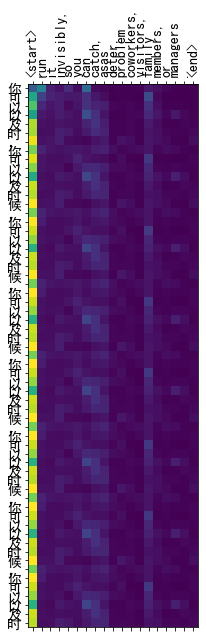

In [33]:
translate('<start> run it invisibly, so you can catch, asas deter, problem coworkers, visitors, family members, or managers . <end>')

inputs [[3, 12, 57, 122, 784, 7, 4063, 1865, 7, 469, 707, 2, 4]]
Input: <start> for more information, see abstract and sealed classes and class members . <end>
Predicted translation: 关 于 更 多 看 到 抽 象 和 密 封 闭 级 培 训 。 <end> 


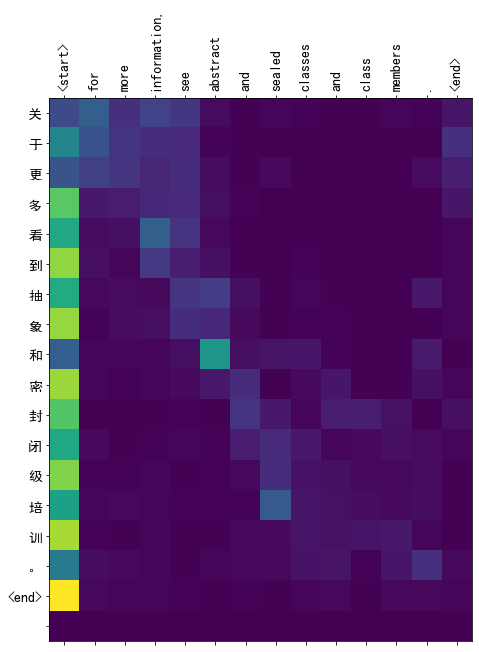

In [34]:
translate('<start> for more information, see abstract and sealed classes and class members . <end>')

inputs [[3, 1951, 22, 521, 29662, 36, 1, 57, 24317, 707, 6, 1, 272, 108, 4]]
Input: <start> mary was sometimes overshadowed by the more talkative members of the family ! <end>
Predicted translation: 有 时 事 后 ， 彼 时 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 钟 头 十 分 


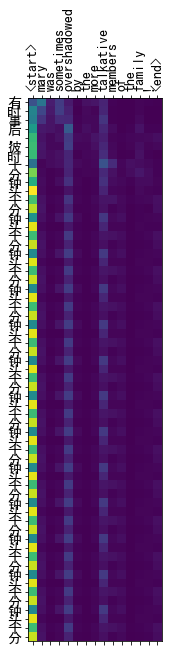

In [35]:
translate('<start> mary was sometimes overshadowed by the more talkative members of the family ! <end>')

inputs [[3, 15, 23, 3292, 4]]
Input: <start> you are lucky <end>
Predicted translation: 你 是 幸 运 是 很 幸 运 。 <end> 


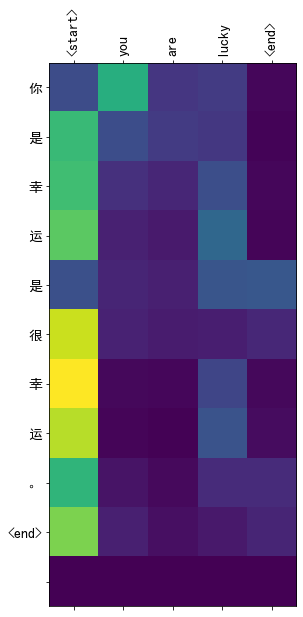

In [36]:
translate('<start> you are lucky <end>')